# Run AR6-fair for my choice of scenarios
# Currently includes 
    - ssp119
    - ssp126
    - ssp245
    - ssp434
    - ssp585


In [1]:
import fair
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.interpolate import interp1d
from multiprocessing import Pool
from tqdm import tqdm
import json
import pickle
#from climateforcing.twolayermodel import TwoLayerModel

In [2]:
# set up plotting
pl.rcParams['figure.figsize'] = (9/2.54, 9/2.54)
pl.rcParams['font.size'] = 12
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['ytick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.major.left'] = True
pl.rcParams['ytick.major.right'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['ytick.right'] = True

In [3]:
with open('../data_input/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

In [4]:
len(config_list)

2237

In [5]:
#scenarios = ['constant_forcing', 'constant_emissions', 'zero', 'scenario', 'infrastructure']
#scenarios = ['constant_emissions', 'zero', 'infrastructure', 'scenario']
# zero and constant emissions will be the easy ones, so start with these.

scenarios = ['ssp119','ssp126','ssp245','ssp370','ssp434','ssp585']

In [6]:
ssp_df = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
years = np.arange(1750, 2111)

startyear = 1750
first_scenyear = 2015
last_scenyear = 2110
first_row = int(first_scenyear-startyear)
last_row = int(last_scenyear-startyear)

species = [  # in fair 1.6, order is important
    '|CO2|MAGICC Fossil and Industrial',
    '|CO2|MAGICC AFOLU',
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|CF4',
    '|C2F6',
    '|C6F14',
    '|HFC23',
    '|HFC32',
    '|HFC4310mee',
    '|HFC125',
    '|HFC134a',
    '|HFC143a',
    '|HFC227ea',
    '|HFC245fa',
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

# Assume that units coming out of aneris don't change. One day I'll do unit parsing
unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

data_out = {}
# 'ssp119','ssp126','ssp245','ssp370',ssp434','ssp585''

for scenario in scenarios:
    data_out[scenario] = np.ones((361, 40)) * np.nan
    data_out[scenario][:,0] = years
    print(scenario)
    years_future = [2015] + list(range(2020,2111,10))
    for i, specie in enumerate(species):
        
        data_out[scenario][:first_row,i+1] = ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scenario)&(ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
        f = interp1d(years_future, ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scenario)&(ssp_df['Variable'].str.endswith(specie)),'2015':'2110'].dropna(axis=1))
        data_out[scenario][first_row:(last_row+1), i+1] = f(np.arange(first_scenyear, last_scenyear+1))*unit_convert[i+1]

ssp119
ssp126
ssp245
ssp370
ssp434
ssp585


In [7]:
#'ssp119'
#data_out['ssp119'][:,1]

In [8]:
#'ssp126'
#data_out['ssp126'][:,1]

In [9]:
#'ssp245'
#data_out['ssp245'][:,1]

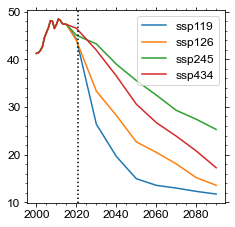

In [10]:
pl.plot(np.arange(2000, 2091), data_out['ssp119'][250:341,8], label='ssp119')
pl.plot(np.arange(2000, 2091), data_out['ssp126'][250:341,8], label='ssp126')
#pl.plot(np.arange(2000, 2091), ssp126[250:341, 39])
pl.plot(np.arange(2000, 2091), data_out['ssp245'][250:341,8], label='ssp245')
pl.plot(np.arange(2000, 2091), data_out['ssp434'][250:341,8], label='ssp434')
pl.axvline(2021, ls=':', color='k')
pl.legend()

# SSP119

In [11]:
results_out = {}

In [12]:
updated_config = []
for i, cfg in enumerate(config_list):
    updated_config.append({})
    for key, value in cfg.items():
        if isinstance(value, list):
            updated_config[i][key] = np.asarray(value)
        else:
            updated_config[i][key] = value
    updated_config[i]['emissions'] = data_out['ssp119']
    updated_config[i]['diagnostics'] = 'AR6'
    updated_config[i]["efficacy"] = np.ones(45)
    updated_config[i]["gir_carbon_cycle"] = True
    updated_config[i]["temperature_function"] = "Geoffroy"
    updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
    updated_config[i]["fixPre1850RCP"] = False
    updated_config[i]["scale"][43] = 0.6

In [13]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|██████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:02<00:00, 36.02it/s]


In [14]:
len(result[0])

5

In [15]:
len(updated_config)

2237

In [16]:
result_t = np.array(result).transpose(1,2,0)

In [17]:
results_out['ssp119'] = {}
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out['ssp119']['co2_conc'] = c
results_out['ssp119']['temp'] = temp_rebase
results_out['ssp119']['F_ant'] = f_ant
results_out['ssp119']['F_aer'] = f_aer
results_out['ssp119']['F_tot'] = f_tot

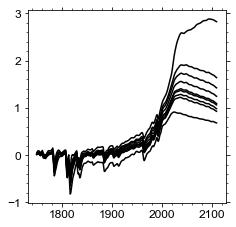

In [18]:
#temp_df = pd.read_csv('../data_input/observations/temp.csv', index_col=0)
#temp_df

for perc in [0,5,10,20,25,50,75,90,100]:
    pl.plot(np.arange(1750,2111),np.percentile(t,perc, axis=1), color='k')


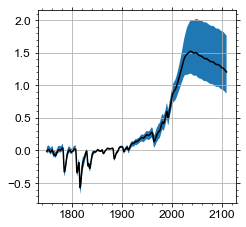

In [19]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['ssp119']['temp'], 5, axis=1), np.percentile(results_out['ssp119']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['ssp119']['temp'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
#pl.ylim(0.0, 1.7)
#pl.xlim(1950, 2030)
pl.grid()

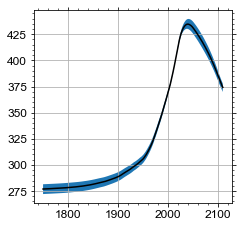

In [20]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['ssp119']['co2_conc'], 5, axis=1), np.percentile(results_out['ssp119']['co2_conc'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['ssp119']['co2_conc'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
#pl.ylim(0.0, 1.7)
#pl.xlim(1950, 2030)
pl.grid()

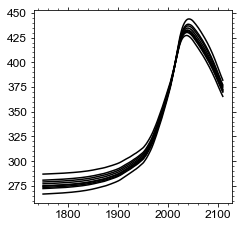

In [21]:
for perc in [0,5,10,20,25,50,75,90,100]:
    pl.plot(np.arange(1750,2111),np.percentile(c,perc, axis=1), color='k')

In [22]:
# pl.fill_between(np.arange(1750,2111), np.percentile(C_CO2, 5, axis=1), np.percentile(C_CO2, 95, axis=1))
# pl.plot(np.arange(1750,2111), np.percentile(C_CO2, 50, axis=1), color='k')
# pl.grid()

In [23]:
# np.percentile(T2, 50, axis=1)[260:270].mean()

In [24]:
# pl.fill_between(np.arange(1750,2111), np.percentile(F_ant, 5, axis=1), np.percentile(F_ant, 95, axis=1))
# pl.plot(np.arange(1750,2111), np.percentile(F_ant, 50, axis=1), color='k')
# pl.grid()

In [25]:
# pl.fill_between(np.arange(1750,2111), np.percentile(F_aer, 5, axis=1), np.percentile(F_aer, 95, axis=1))
# pl.plot(np.arange(1750,2111), np.percentile(F_aer, 50, axis=1), color='k')
# pl.grid()

In [26]:
np.median(results_out['ssp119']['temp'], axis=1)[245:265].mean()

0.8748613261824711

In [27]:
# aerosol forcing is a little less negative than in WG3 because we use CEDS-updated not SSP historical
print(
    np.percentile(results_out['ssp119']['F_aer'], 5, axis=1)[255:265].mean(),
    np.percentile(results_out['ssp119']['F_aer'], 50, axis=1)[255:265].mean(),
    np.percentile(results_out['ssp119']['F_aer'], 95, axis=1)[255:265].mean()
)

-1.682424405295849 -1.1481288263143208 -0.5985614310182676


# ssp126

In [28]:
for i, cfg in enumerate(updated_config):
    updated_config[i]['emissions'] = data_out['ssp126']

In [29]:
if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|██████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:01<00:00, 36.52it/s]


In [30]:
results_out['ssp126'] = {}
result_t = np.array(result).transpose(1,2,0)
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out['ssp126']['co2_conc'] = c
results_out['ssp126']['temp'] = temp_rebase
results_out['ssp126']['F_ant'] = f_ant
results_out['ssp126']['F_aer'] = f_aer
results_out['ssp126']['F_tot'] = f_tot

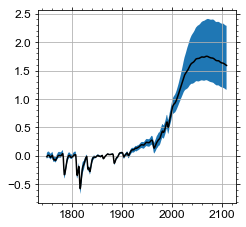

In [31]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['ssp126']['temp'], 5, axis=1), np.percentile(results_out['ssp126']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['ssp126']['temp'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
#pl.ylim(0.0, 1.7)
#pl.xlim(1950, 2030)
pl.grid()

# ssp245

In [32]:
for i, cfg in enumerate(updated_config):
    updated_config[i]['emissions'] = data_out['ssp245']

In [33]:
if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|██████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:00<00:00, 37.17it/s]


In [34]:
results_out['ssp245'] = {}
result_t = np.array(result).transpose(1,2,0)
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out['ssp245']['co2_conc'] = c
results_out['ssp245']['temp'] = temp_rebase
results_out['ssp245']['F_ant'] = f_ant
results_out['ssp245']['F_aer'] = f_aer
results_out['ssp245']['F_tot'] = f_tot

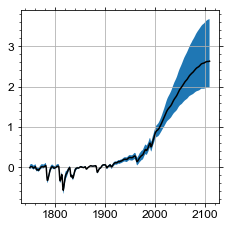

In [35]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['ssp245']['temp'], 5, axis=1), np.percentile(results_out['ssp245']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['ssp245']['temp'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
#pl.ylim(0.0, 1.7)
#pl.xlim(1950, 2030)
pl.grid()

# ssp434

In [36]:
for i, cfg in enumerate(updated_config):
    updated_config[i]['emissions'] = data_out['ssp434']

In [37]:
if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|██████████████████████████████████████████████████████████████████████████████████| 2237/2237 [00:58<00:00, 38.34it/s]


In [38]:
results_out['ssp434'] = {}
result_t = np.array(result).transpose(1,2,0)
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out['ssp434']['co2_conc'] = c
results_out['ssp434']['temp'] = temp_rebase
results_out['ssp434']['F_ant'] = f_ant
results_out['ssp434']['F_aer'] = f_aer
results_out['ssp434']['F_tot'] = f_tot

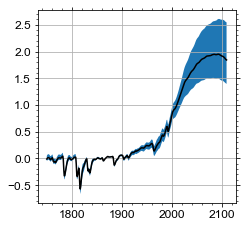

In [39]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['ssp434']['temp'], 5, axis=1), np.percentile(results_out['ssp434']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['ssp434']['temp'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
pl.grid()

# ssp370

In [40]:
for i, cfg in enumerate(updated_config):
    updated_config[i]['emissions'] = data_out['ssp370']

In [41]:
if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|██████████████████████████████████████████████████████████████████████████████████| 2237/2237 [00:55<00:00, 40.40it/s]


In [42]:
results_out['ssp370'] = {}
result_t = np.array(result).transpose(1,2,0)
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out['ssp370']['co2_conc'] = c
results_out['ssp370']['temp'] = temp_rebase
results_out['ssp370']['F_ant'] = f_ant
results_out['ssp370']['F_aer'] = f_aer
results_out['ssp370']['F_tot'] = f_tot

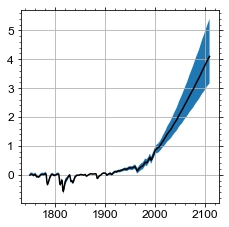

In [43]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['ssp370']['temp'], 5, axis=1), np.percentile(results_out['ssp370']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['ssp370']['temp'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
pl.grid()

# ssp585

In [44]:
for i, cfg in enumerate(updated_config):
    updated_config[i]['emissions'] = data_out['ssp585']

if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|██████████████████████████████████████████████████████████████████████████████████| 2237/2237 [00:55<00:00, 40.65it/s]


In [45]:
results_out['ssp585'] = {}
result_t = np.array(result).transpose(1,2,0)
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out['ssp585']['co2_conc'] = c
results_out['ssp585']['temp'] = temp_rebase
results_out['ssp585']['F_ant'] = f_ant
results_out['ssp585']['F_aer'] = f_aer
results_out['ssp585']['F_tot'] = f_tot

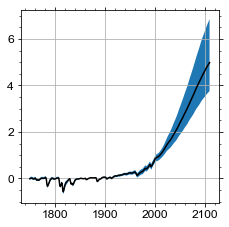

In [46]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['ssp585']['temp'], 5, axis=1), np.percentile(results_out['ssp585']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['ssp585']['temp'], 50, axis=1), color='k')
#pl.plot(temp_df.index, temp_df.temp, color='r')
pl.grid()

# All on the same plot!

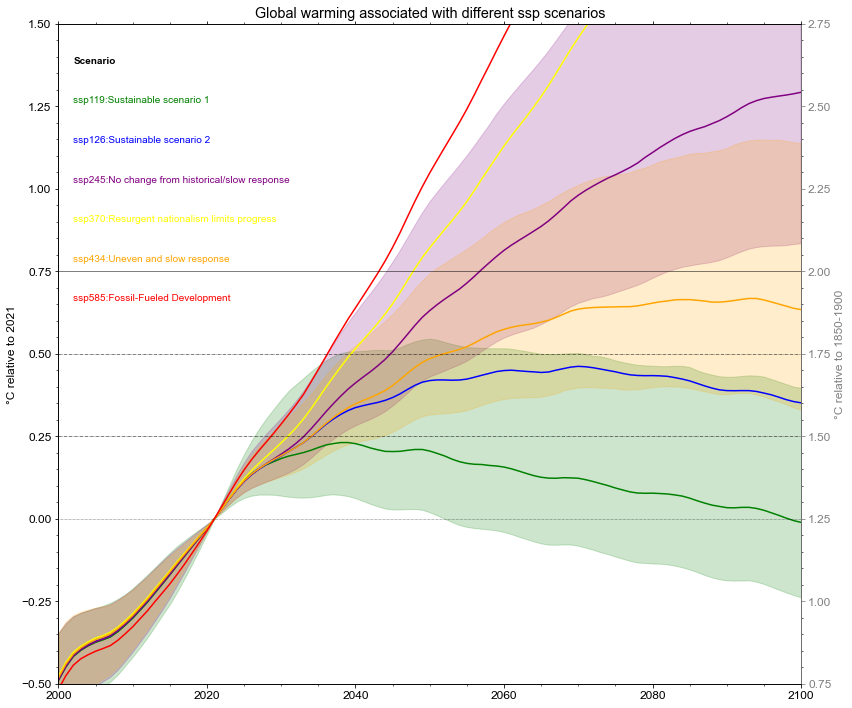

In [47]:
#scenarios = ['zero', 'constant_forcing', 'constant_emissions', 'infrastructure', 'scenario']
scenarios = ['ssp119',  'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp585']
colors = {
    'ssp119' : 'green',
    'ssp126' : 'blue',
    'ssp245' : 'purple',
    'ssp370' : 'yellow',
    'ssp434' : 'orange',
    'ssp585' : 'red'
    }

labels = {
    'ssp119' : 'ssp119:Sustainable scenario 1',
    'ssp126' : 'ssp126:Sustainable scenario 2',
    'ssp245' : 'ssp245:No change from historical/slow response',
    'ssp370' : 'ssp370:Resurgent nationalism limits progress',
    'ssp434' : 'ssp434:Uneven and slow response',
    'ssp585' : 'ssp585:Fossil-Fueled Development'
}

fig, ax = pl.subplots(figsize=(12, 10))

ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=10, transform=ax.transAxes)
for i, scenario in enumerate(['ssp119', 'ssp126', 'ssp245','ssp370','ssp434','ssp585']):
    if scenario in ['ssp119', 'ssp245', 'ssp434']:
        ax.fill_between(np.arange(2000,2101), np.percentile(results_out[scenario]['temp'][250:351,:] - results_out[scenario]['temp'][271,:], 5, axis=1), np.percentile(results_out[scenario]['temp'][250:351,:] - results_out[scenario]['temp'][271,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['temp'][250:351,:] - results_out[scenario]['temp'][271,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=10)
#ax.legend(fontsize=10);
ax.set_ylabel('°C relative to 2021');
ax.set_title('Global warming associated with different ssp scenarios');
ax.set_xlim(2000, 2100)
ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker

ax1 = ax.twinx()
positions = np.arange(0.75, 2.76, 0.25)
#ax1.plot(temp_df.index[150:], temp_df.temp[150:], color='k')
ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))
#ax1[3].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
ax1.set_ylim(0.75,2.75)
ax1.spines['right'].set_color('gray')
ax1.tick_params(axis='y', colors='gray')
ax1.set_ylabel('°C relative to 1850-1900', color='gray')
#ax1.set_yticklabels(np.arange(0.75, 2.26, 0.25))
#pl.grid()

ax.axhline(0, ls=':', color='k', lw=0.5)
ax1.axhline(1.5, ls='-.', color='k', lw=0.5)
ax1.axhline(1.75, ls='-.', color='k', lw=0.5)
ax1.axhline(2.0, ls='-', color='k', lw=0.5)
fig.tight_layout()
pl.savefig('../plots/rcmip_scenarios_temp.png', dpi=500, transparent=False)

In [48]:
with open('../processed/commit_results_rcmipscenarios.pkl', 'wb') as f:
    pickle.dump(results_out, f)

In [49]:
#temp_df.temp[150:].values

# All on the same plot CO2 conc!

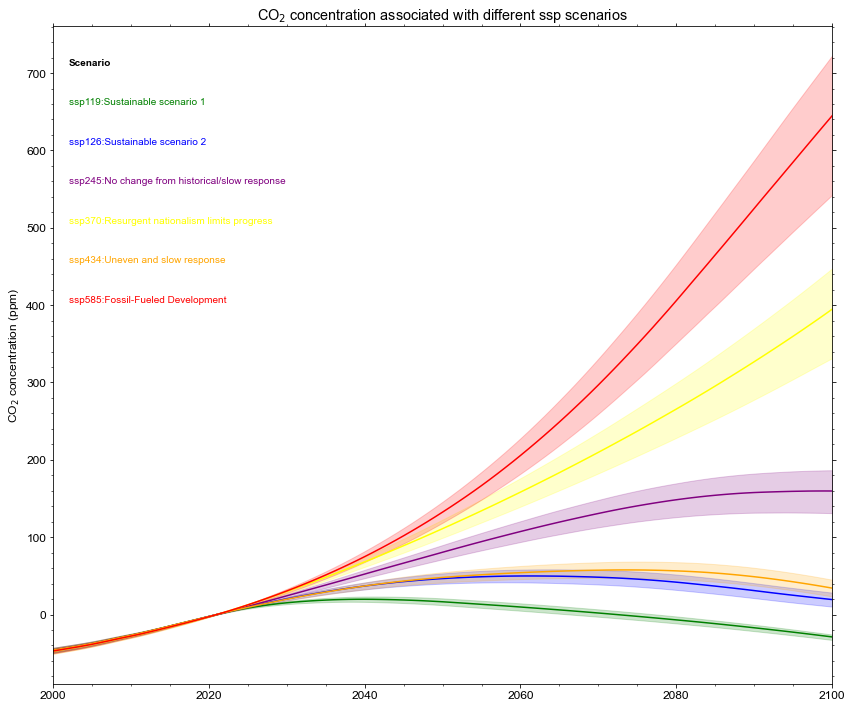

In [50]:
fig, ax = pl.subplots(figsize=(12, 10))

ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=10, transform=ax.transAxes)
for i, scenario in enumerate(['ssp119', 'ssp126', 'ssp245', 'ssp370','ssp434','ssp585']):
    #if scenario in ['ssp119', 'ssp245', 'ssp434']:
    ax.fill_between(np.arange(2000,2101), np.percentile(results_out[scenario]['co2_conc'][250:351,:] - results_out[scenario]['co2_conc'][271,:], 5, axis=1), np.percentile(results_out[scenario]['co2_conc'][250:351,:] - results_out[scenario]['co2_conc'][271,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['co2_conc'][250:351,:] - results_out[scenario]['co2_conc'][271,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=10)
#ax.legend(fontsize=10);
ax.set_ylabel(r'CO${_2}$ concentration (ppm)');
ax.set_title(r'CO${_2}$ concentration associated with different ssp scenarios');
ax.set_xlim(2000, 2100)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker

#ax1 = ax.twinx()
#positions = np.arange(0.75, 2.76, 0.25)
#ax1.plot(temp_df.index[150:], temp_df.temp[150:], color='k')
ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))
#ax1[3].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
#ax1.set_ylim(0.75,2.75)
ax1.spines['right'].set_color('gray')
ax1.tick_params(axis='y', colors='gray')
#ax1.set_ylabel('CO2 concentrations relative to 1850-1900', color='gray')
#ax1.set_yticklabels(np.arange(0.75, 2.26, 0.25))
#pl.grid()

#ax.axhline(0, ls=':', color='k', lw=0.5)
#ax1.axhline(1.5, ls='-.', color='k', lw=0.5)
#ax1.axhline(2.0, ls='-', color='k', lw=0.5)
fig.tight_layout()
pl.savefig('../plots/rcmip_scenarios_CO2conc.png', dpi=500, transparent=False)

# All on the same plot ERF!

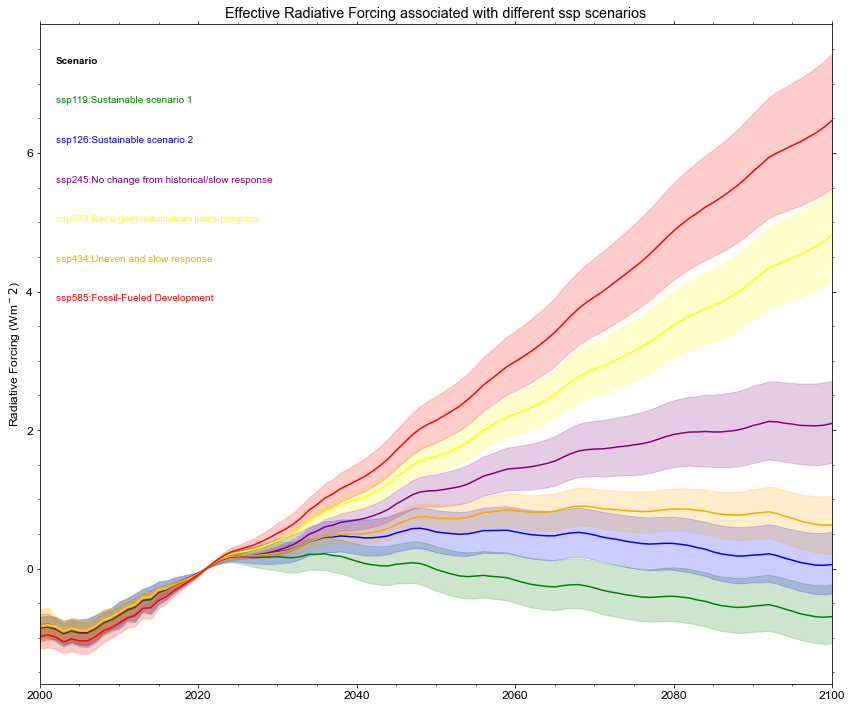

In [51]:
fig, ax = pl.subplots(figsize=(12, 10))

ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=10, transform=ax.transAxes)
for i, scenario in enumerate(['ssp119', 'ssp126', 'ssp245', 'ssp370','ssp434','ssp585']):
    #if scenario in ['ssp119', 'ssp245', 'ssp434']:
    ax.fill_between(np.arange(2000,2101), np.percentile(results_out[scenario]['F_tot'][250:351,:] - results_out[scenario]['F_tot'][271,:], 5, axis=1), np.percentile(results_out[scenario]['F_tot'][250:351,:] - results_out[scenario]['F_tot'][271,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['F_tot'][250:351,:] - results_out[scenario]['F_tot'][271,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=10)
#ax.legend(fontsize=10);
ax.set_ylabel(r'Radiative Forcing (Wm${^-2}$)');
ax.set_title('Effective Radiative Forcing associated with different ssp scenarios');
ax.set_xlim(2000, 2100)
#ax.set_ylim(-0.5, 1.5)

from matplotlib import ticker

#ax1 = ax.twinx()
#positions = np.arange(0.75, 2.76, 0.25)
#ax1.plot(temp_df.index[150:], temp_df.temp[150:], color='k')
ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))
#ax1[3].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
#ax1.set_ylim(0.75,2.75)
ax1.spines['right'].set_color('gray')
ax1.tick_params(axis='y', colors='gray')
#ax1.set_ylabel('CO2 concentrations relative to 1850-1900', color='gray')
#ax1.set_yticklabels(np.arange(0.75, 2.26, 0.25))
#pl.grid()

#ax.axhline(0, ls=':', color='k', lw=0.5)
#ax1.axhline(1.5, ls='-.', color='k', lw=0.5)
#ax1.axhline(2.0, ls='-', color='k', lw=0.5)
fig.tight_layout()
pl.savefig('../plots/rcmip_scenarios_erf.png', dpi=500, transparent=False)

In [52]:
# Extract some numbers from the output to compare with IPCC

In [53]:
print('SSP119')

print('1995-2014', 'central', np.median(results_out['ssp119']['temp'][245:265]).mean()) 
print('1995-2014', '5th',np.percentile(results_out['ssp119']['temp'],5,axis=1)[245:265].mean())
print('1995-2014', '95th',np.percentile(results_out['ssp119']['temp'],95,axis=1)[245:265].mean())

print('2021-2040', 'central', np.median(results_out['ssp119']['temp'][271:290]).mean()) 
print('2021-2040', '5th',np.percentile(results_out['ssp119']['temp'],5,axis=1)[271:290].mean())
print('2021-2040', '95th',np.percentile(results_out['ssp119']['temp'],95,axis=1)[271:290].mean())

print('2041-2060', 'central', np.median(results_out['ssp119']['temp'][291:310]).mean()) 
print('2041-2060', '5th',np.percentile(results_out['ssp119']['temp'],5,axis=1)[291:310].mean())
print('2041-2060', '95th',np.percentile(results_out['ssp119']['temp'],95,axis=1)[291:310].mean())

print('2081-2100', 'central', np.median(results_out['ssp119']['temp'][331:350]).mean()) 
print('2081-2100', '5th',np.percentile(results_out['ssp119']['temp'],5,axis=1)[331:350].mean())
print('2081-2100', '95th',np.percentile(results_out['ssp119']['temp'],95,axis=1)[331:350].mean())


SSP119
1995-2014 central 0.8812089627260413
1995-2014 5th 0.7193117503319397
1995-2014 95th 1.018117210705426
2021-2040 central 1.4403305139128055
2021-2040 5th 1.1485897837632693
2021-2040 95th 1.8265630098437187
2041-2060 central 1.4841585241713835
2041-2060 5th 1.1330382553387517
2041-2060 95th 2.0044756791930483
2081-2100 central 1.325229500777222
2081-2100 5th 0.9819600604339709
2081-2100 95th 1.8786204486039495


In [54]:
temp_anomaly = results_out['ssp119']['temp'] - results_out['ssp119']['temp'][245:265,:].mean(axis=0)

#np.median(temp_anomaly,axis=1)[271:290].mean()
print('SSP119  ',  '        5th         50th              95th  ' )
print('2021-2040', np.percentile(temp_anomaly,5,axis=1)[271:291].mean(), 
      np.percentile(temp_anomaly,50,axis=1)[271:291].mean(), 
      np.percentile(temp_anomaly,95,axis=1)[271:291].mean()
     ) 

print('2041-2060', np.percentile(temp_anomaly,5,axis=1)[291:310].mean(), 
      np.percentile(temp_anomaly,50,axis=1)[291:310].mean(),
      np.percentile(temp_anomaly,95,axis=1)[291:310].mean()
     ) 

print('2081-2100', np.percentile(temp_anomaly,5,axis=1)[331:350].mean(), 
      np.percentile(temp_anomaly,50,axis=1)[331:350].mean(),
      np.percentile(temp_anomaly,95,axis=1)[331:350].mean()
     ) 
#np.median(temp_anomaly,axis=1)[291:310].mean()
#np.median(temp_anomaly,axis=1)[331:350].mean()

SSP119           5th         50th              95th  
2021-2040 0.35673510395387537 0.5764626514884964 0.890408616725162
2041-2060 0.31651746563766026 0.6068111781120679 1.0740034725974503
2081-2100 0.14998318855997253 0.45019831972011437 0.9732475275224072


In [55]:
temp_anomaly = results_out['ssp126']['temp'] - results_out['ssp126']['temp'][245:265,:].mean(axis=0)

#np.median(temp_anomaly,axis=1)[271:290].mean()
print('SSP126  ',  '        5th         50th              95th  ' )
print('2021-2040', np.percentile(temp_anomaly,5,axis=1)[271:291].mean(), 
      np.percentile(temp_anomaly,50,axis=1)[271:291].mean(), 
      np.percentile(temp_anomaly,95,axis=1)[271:291].mean()
     ) 

print('2041-2060', np.percentile(temp_anomaly,5,axis=1)[291:310].mean(), 
      np.percentile(temp_anomaly,50,axis=1)[291:310].mean(),
      np.percentile(temp_anomaly,95,axis=1)[291:310].mean()
     ) 

print('2081-2100', np.percentile(temp_anomaly,5,axis=1)[331:350].mean(), 
      np.percentile(temp_anomaly,50,axis=1)[331:350].mean(),
      np.percentile(temp_anomaly,95,axis=1)[331:350].mean()
     ) 

SSP126           5th         50th              95th  
2021-2040 0.3889907998202175 0.6021725330313865 0.9122364253445193
2041-2060 0.48896546294736104 0.8118151886192804 1.3196603868798433
2081-2100 0.43399766097328785 0.8031179346417038 1.4473023097519477


In [56]:
print('GSAT WARMING 1995-2014 relative to 1850-1900')
print(np.percentile(results_out['ssp119']['temp'],5,axis=1)[245:265].mean(axis=0),
      np.percentile(results_out['ssp119']['temp'],50,axis=1)[245:265].mean(axis=0),
      np.percentile(results_out['ssp119']['temp'],95,axis=1)[245:265].mean(axis=0))

for scenario in ['ssp119', 'ssp126','ssp245','ssp370','ssp434', 'ssp585']:
    temp_anomaly = results_out[scenario]['temp'] - results_out[scenario]['temp'][245:265,:].mean(axis=0)
    print(' ')
    print (scenario.upper()+'         5th                    50th                95th')
    print('2021-2040', np.percentile(temp_anomaly,5,axis=1)[271:291].mean(), 
      np.percentile(temp_anomaly,50,axis=1)[271:291].mean(), 
      np.percentile(temp_anomaly,95,axis=1)[271:291].mean()
     ) 

    print('2041-2060', np.percentile(temp_anomaly,5,axis=1)[291:310].mean(), 
      np.percentile(temp_anomaly,50,axis=1)[291:310].mean(),
      np.percentile(temp_anomaly,95,axis=1)[291:310].mean()
     ) 

    print('2081-2100', np.percentile(temp_anomaly,5,axis=1)[331:350].mean(), 
      np.percentile(temp_anomaly,50,axis=1)[331:350].mean(),
      np.percentile(temp_anomaly,95,axis=1)[331:350].mean()
     ) 
    

GSAT WARMING 1995-2014 relative to 1850-1900
0.7193117503319397 0.8748613261824711 1.018117210705426
 
SSP119         5th                    50th                95th
2021-2040 0.35673510395387537 0.5764626514884964 0.890408616725162
2041-2060 0.31651746563766026 0.6068111781120679 1.0740034725974503
2081-2100 0.14998318855997253 0.45019831972011437 0.9732475275224072
 
SSP126         5th                    50th                95th
2021-2040 0.3889907998202175 0.6021725330313865 0.9122364253445193
2041-2060 0.48896546294736104 0.8118151886192804 1.3196603868798433
2081-2100 0.43399766097328785 0.8031179346417038 1.4473023097519477
 
SSP245         5th                    50th                95th
2021-2040 0.44717092018020166 0.6219241475095885 0.8734004211849682
2041-2060 0.7234220806470487 1.028939176553451 1.4885910605530785
2081-2100 1.10505741983212 1.6321916693730365 2.5232908677396018
 
SSP370         5th                    50th                95th
2021-2040 0.4889948835900707 0.65